In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!nvidia-smi

c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\frame

Sun Apr 21 13:16:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8                4W /  N/A|      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    validation_split=0.2  
)

In [3]:
train_img = train_datagen.flow_from_directory('train' ,class_mode='binary'
, batch_size=64 , subset="training",target_size=(32, 32) ,shuffle=True)
valid_img = train_datagen.flow_from_directory('train' ,class_mode='binary'
, batch_size=64 ,subset="validation", target_size=(32, 32),shuffle=True)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
print(train_img.class_indices)
print(valid_img.class_indices)

{'FAKE': 0, 'REAL': 1}
{'FAKE': 0, 'REAL': 1}


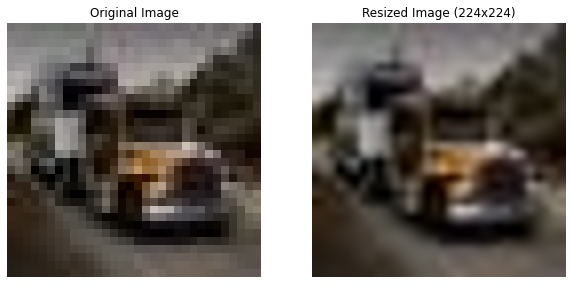

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the original image
im = Image.open("train/FAKE/1000 (10).jpg")

# Define the new size
new_size = (224, 224)

# Resize the image
im_resized = im.resize(new_size)

# Plot the original and resized images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original Image')
plt.axis('off')

# Plot the resized image
plt.subplot(1, 2, 2)
plt.imshow(im_resized)
plt.title('Resized Image (224x224)')
plt.axis('off')

plt.show()

In [6]:
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                        input_tensor=Input(shape=(32, 32, 3)))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [8]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
modelVGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [16]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
modelVGG16.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# early_stopping : val_loss 連續不降低時，結束訓練
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1,restore_best_weights=True,mode='auto')
# reduce_lr : val_loss 連續不降低時，減少learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto',
                            epsilon=0.0001, cooldown=0, min_lr=0)

checkpoint = ModelCheckpoint('VGG16_tf1_v3.h5', monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [17]:
history = modelVGG16.fit(train_img,
                    validation_data=valid_img,
                    epochs=20,callbacks=[early_stopping,checkpoint,reduce_lr]
)

Epoch 1/20
313/313 [==============================] - 411s 1s/step - loss: 0.3448 - acc: 0.8540

Epoch 00001: val_loss improved from inf to 0.34477, saving model to VGG16_tf1_v3.h5
1250/1250 [==============================] - 5174s 4s/step - loss: 0.3869 - acc: 0.8149 - val_loss: 0.3448 - val_acc: 0.8540
Epoch 2/20
313/313 [==============================] - 176s 563ms/step - loss: 0.2632 - acc: 0.8895

Epoch 00002: val_loss improved from 0.34477 to 0.26316, saving model to VGG16_tf1_v3.h5
1250/1250 [==============================] - 4547s 4s/step - loss: 0.3213 - acc: 0.8616 - val_loss: 0.2632 - val_acc: 0.8895
Epoch 3/20
313/313 [==============================] - 176s 563ms/step - loss: 0.2298 - acc: 0.9074

Epoch 00003: val_loss improved from 0.26316 to 0.22975, saving model to VGG16_tf1_v3.h5
1250/1250 [==============================] - 4542s 4s/step - loss: 0.2518 - acc: 0.8949 - val_loss: 0.2298 - val_acc: 0.9074
Epoch 4/20
313/313 [==============================] - 175s 559ms/ste

KeyboardInterrupt: 

In [12]:
val_loss =history.history['val_loss']

# พล็อต validation loss
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('test', target_size=(32,32),
                                                  batch_size=64, class_mode='binary', shuffle=False)

Found 20000 images belonging to 2 classes.


In [18]:
scores = modelVGG16.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

313/313 [==============================] - 81s 259ms/step - loss: 0.1842 - acc: 0.9232 - precision: 0.9793 - recall: 0.8646
Baseline error: 0.08
Accuracy = 0.92


In [19]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)


Accuracy: 0.92315

Confusion Matrix:
[[9817  183]
 [1354 8646]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.88      0.98      0.93     10000
        REAL       0.98      0.86      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93      0.92      0.92     20000


Mean Average Precision (mAP): 0.9883838420522467


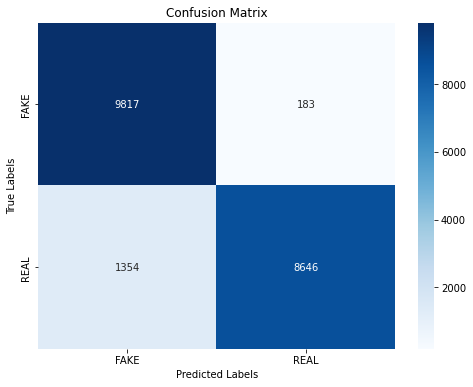

In [22]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

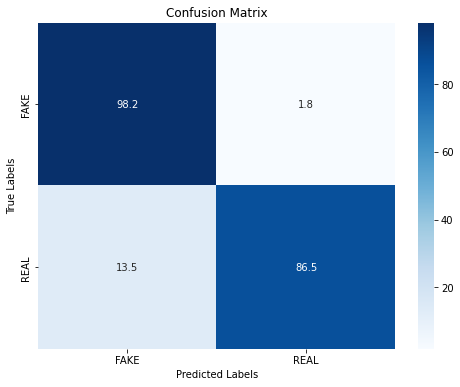

In [23]:
# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
modelVGG16.save('models/VGG16_tf1_v2.h5', overwrite=True)